In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.4.0 True
2.4.0
10.1
GCC 7.3


In [2]:
import itertools
import logging
import os.path as osp
import tempfile

import mmcv
import numpy as np
from mmcv.utils import print_log
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from terminaltables import AsciiTable

from mmdet.core import eval_recalls
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

try:
    import pycocotools
    assert pycocotools.__version__ >= '12.0.2'
except AssertionError:
    raise AssertionError('Incompatible version of pycocotools is installed. '
                         'Run pip uninstall pycocotools first. Then run pip '
                         'install mmpycocotools to install open-mmlab forked '
                         'pycocotools.')

@DATASETS.register_module()
class LotteDataset(CustomDataset):

    CLASSES = ('ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 
               'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 
               'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 
               'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 
               'vita500', 'welchs', 'zec')

    def load_annotations(self, ann_file):
        """Load annotation from COCO style annotation file.

        Args:
            ann_file (str): Path of annotation file.

        Returns:
            list[dict]: Annotation info from COCO api.
        """

        self.coco = COCO(ann_file)
        self.cat_ids = self.coco.get_cat_ids(cat_names=self.CLASSES)
        self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
        self.img_ids = self.coco.get_img_ids()
        data_infos = []
        for i in self.img_ids:
            info = self.coco.load_imgs([i])[0]
            info['filename'] = info['file_name']
            data_infos.append(info)
        return data_infos

    def get_ann_info(self, idx):
        """Get COCO annotation by index.

        Args:
            idx (int): Index of data.

        Returns:
            dict: Annotation info of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return self._parse_ann_info(self.data_infos[idx], ann_info)

    def get_cat_ids(self, idx):
        """Get COCO category ids by index.

        Args:
            idx (int): Index of data.

        Returns:
            list[int]: All categories in the image of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return [ann['category_id'] for ann in ann_info]

    def _filter_imgs(self, min_size=32):
        """Filter images too small or without ground truths."""
        valid_inds = []
        ids_with_ann = set(_['image_id'] for _ in self.coco.anns.values())
        for i, img_info in enumerate(self.data_infos):
            if self.filter_empty_gt and self.img_ids[i] not in ids_with_ann:
                continue
            if min(img_info['width'], img_info['height']) >= min_size:
                valid_inds.append(i)
        return valid_inds

    def get_subset_by_classes(self):
        """Get img ids that contain any category in class_ids.

        Different from the coco.getImgIds(), this function returns the id if
        the img contains one of the categories rather than all.

        Args:
            class_ids (list[int]): list of category ids

        Return:
            ids (list[int]): integer list of img ids
        """

        ids = set()
        for i, class_id in enumerate(self.cat_ids):
            ids |= set(self.coco.cat_img_map[class_id])
        self.img_ids = list(ids)

        data_infos = []
        for i in self.img_ids:
            info = self.coco.load_imgs([i])[0]
            info['filename'] = info['file_name']
            data_infos.append(info)
        return data_infos

    def _parse_ann_info(self, img_info, ann_info):
        """Parse bbox and mask annotation.

        Args:
            ann_info (list[dict]): Annotation info of an image.
            with_mask (bool): Whether to parse mask annotations.

        Returns:
            dict: A dict containing the following keys: bboxes, bboxes_ignore,\
                labels, masks, seg_map. "masks" are raw annotations and not \
                decoded into binary masks.
        """
        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []
        gt_masks_ann = []
        for i, ann in enumerate(ann_info):
            if ann.get('ignore', False):
                continue
            x1, y1, w, h = ann['bbox']
            inter_w = max(0, min(x1 + w, img_info['width']) - max(x1, 0))
            inter_h = max(0, min(y1 + h, img_info['height']) - max(y1, 0))
            if inter_w * inter_h == 0:
                continue
            if ann['area'] <= 0 or w < 1 or h < 1:
                continue
            if ann['category_id'] not in self.cat_ids:
                continue
            bbox = [x1, y1, x1 + w, y1 + h]
            if ann.get('iscrowd', False):
                gt_bboxes_ignore.append(bbox)
            else:
                gt_bboxes.append(bbox)
                gt_labels.append(self.cat2label[ann['category_id']])
                gt_masks_ann.append(ann.get('segmentation', None))

        if gt_bboxes:
            gt_bboxes = np.array(gt_bboxes, dtype=np.float32)
            gt_labels = np.array(gt_labels, dtype=np.int64)
        else:
            gt_bboxes = np.zeros((0, 4), dtype=np.float32)
            gt_labels = np.array([], dtype=np.int64)

        if gt_bboxes_ignore:
            gt_bboxes_ignore = np.array(gt_bboxes_ignore, dtype=np.float32)
        else:
            gt_bboxes_ignore = np.zeros((0, 4), dtype=np.float32)

        seg_map = img_info['filename'].replace('jpg', 'png')

        ann = dict(
            bboxes=gt_bboxes,
            labels=gt_labels,
            bboxes_ignore=gt_bboxes_ignore,
            masks=gt_masks_ann,
            seg_map=seg_map)

        return ann

In [3]:
from mmcv import Config
cfg = Config.fromfile('./mmdetection/configs/faster_rcnn/faster_rcnn_r101_fpn_1x_coco.py')

In [4]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'LotteDataset'
cfg.data_root = 'datasets/'

cfg.data.train.type = 'LotteDataset'
cfg.data.train.data_root = 'datasets/'
cfg.data.train.ann_file = 'train/traincoco.json'
cfg.data.train.img_prefix = 'train/images/'

cfg.data.val.type = 'LotteDataset'
cfg.data.val.data_root = 'datasets/'
cfg.data.val.ann_file = 'val/valcoco.json'
cfg.data.val.img_prefix = 'val/images/'

cfg.data.test.type = 'LotteDataset'
cfg.data.test.data_root = 'datasets/'
cfg.data.test.ann_file = 'test/testcoco.json'
cfg.data.test.img_prefix = 'test/images/'

# num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 22
cfg.work_dir = './tutorial_exps'

# original learning rate는 GPU가 8개이므로, 자신의 GPU의 개수에 맞게 변형
cfg.optimizer.lr = 0.02 / 8 # 한 개만 쓸거니까
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
# set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# ㄴet seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    pretrained='torchvision://resnet101',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(t

In [5]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 구축
datasets = [build_dataset(cfg.data.train)]

# detector 구축
model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2020-10-01 13:42:21,046 - mmdet - INFO - load model from: torchvision://resnet101
2020-10-01 13:42:21,251 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2020-10-01 13:42:22,555 - mmdet - INFO - Start running, host: jmh@jmh-GE75-Raider-10SF, work_dir: /home/jmh/content/mmdetection_object_detection_demo/tutorial_exps
2020-10-01 13:42:22,556 - mmdet - INFO - workflow: [('train', 1)], max: 12 epochs


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


2020-10-01 13:42:31,891 - mmdet - INFO - Epoch [1][10/601]	lr: 4.746e-05, eta: 1:41:31, time: 0.846, data_time: 0.213, memory: 5683, loss_rpn_cls: 0.6926, loss_rpn_bbox: 0.0715, loss_cls: 2.6039, acc: 62.8027, loss_bbox: 0.0294, loss: 3.3975
2020-10-01 13:42:37,628 - mmdet - INFO - Epoch [1][20/601]	lr: 9.741e-05, eta: 1:25:04, time: 0.574, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.6912, loss_rpn_bbox: 0.0729, loss_cls: 1.0198, acc: 97.5098, loss_bbox: 0.0349, loss: 1.8187
2020-10-01 13:42:43,348 - mmdet - INFO - Epoch [1][30/601]	lr: 1.474e-04, eta: 1:19:27, time: 0.572, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.6731, loss_rpn_bbox: 0.0970, loss_cls: 0.2439, acc: 96.8945, loss_bbox: 0.0564, loss: 1.0704
2020-10-01 13:42:49,388 - mmdet - INFO - Epoch [1][40/601]	lr: 1.973e-04, eta: 1:17:33, time: 0.604, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.6068, loss_rpn_bbox: 0.0796, loss_cls: 0.4109, acc: 95.2832, loss_bbox: 0.1283, loss: 1.2255
2020-10-01 13:42:55,379 - mmdet 

2020-10-01 13:45:51,431 - mmdet - INFO - Epoch [1][350/601]	lr: 1.746e-03, eta: 1:07:57, time: 0.610, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0204, loss_rpn_bbox: 0.0663, loss_cls: 0.4210, acc: 86.6895, loss_bbox: 0.5811, loss: 1.0888
2020-10-01 13:45:57,702 - mmdet - INFO - Epoch [1][360/601]	lr: 1.796e-03, eta: 1:07:58, time: 0.627, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0207, loss_rpn_bbox: 0.0577, loss_cls: 0.3829, acc: 87.6367, loss_bbox: 0.5580, loss: 1.0194
2020-10-01 13:46:03,901 - mmdet - INFO - Epoch [1][370/601]	lr: 1.846e-03, eta: 1:07:56, time: 0.620, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0207, loss_rpn_bbox: 0.0503, loss_cls: 0.3582, acc: 88.2910, loss_bbox: 0.5643, loss: 0.9936
2020-10-01 13:46:09,851 - mmdet - INFO - Epoch [1][380/601]	lr: 1.896e-03, eta: 1:07:50, time: 0.595, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0169, loss_rpn_bbox: 0.0526, loss_cls: 0.3100, acc: 89.6777, loss_bbox: 0.5396, loss: 0.9191
2020-10-01 13:46:15,955 - mm

2020-10-01 13:49:19,756 - mmdet - INFO - Epoch [2][90/601]	lr: 2.500e-03, eta: 1:05:23, time: 0.602, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0094, loss_rpn_bbox: 0.0492, loss_cls: 0.2282, acc: 92.3145, loss_bbox: 0.4153, loss: 0.7021
2020-10-01 13:49:25,986 - mmdet - INFO - Epoch [2][100/601]	lr: 2.500e-03, eta: 1:05:19, time: 0.623, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0198, loss_rpn_bbox: 0.0399, loss_cls: 0.2495, acc: 92.3535, loss_bbox: 0.4167, loss: 0.7258
2020-10-01 13:49:31,800 - mmdet - INFO - Epoch [2][110/601]	lr: 2.500e-03, eta: 1:05:11, time: 0.581, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0117, loss_rpn_bbox: 0.0440, loss_cls: 0.2469, acc: 91.8652, loss_bbox: 0.4273, loss: 0.7299
2020-10-01 13:49:38,068 - mmdet - INFO - Epoch [2][120/601]	lr: 2.500e-03, eta: 1:05:07, time: 0.627, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0096, loss_rpn_bbox: 0.0386, loss_cls: 0.2939, acc: 91.8164, loss_bbox: 0.3987, loss: 0.7408
2020-10-01 13:49:43,742 - mmd

2020-10-01 13:52:44,286 - mmdet - INFO - Epoch [2][430/601]	lr: 2.500e-03, eta: 1:01:58, time: 0.611, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0079, loss_rpn_bbox: 0.0380, loss_cls: 0.1861, acc: 93.6914, loss_bbox: 0.3499, loss: 0.5819
2020-10-01 13:52:50,289 - mmdet - INFO - Epoch [2][440/601]	lr: 2.500e-03, eta: 1:01:52, time: 0.600, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0083, loss_rpn_bbox: 0.0391, loss_cls: 0.1931, acc: 93.4082, loss_bbox: 0.3523, loss: 0.5929
2020-10-01 13:52:56,397 - mmdet - INFO - Epoch [2][450/601]	lr: 2.500e-03, eta: 1:01:46, time: 0.611, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0082, loss_rpn_bbox: 0.0378, loss_cls: 0.1818, acc: 94.2480, loss_bbox: 0.3419, loss: 0.5697
2020-10-01 13:53:02,363 - mmdet - INFO - Epoch [2][460/601]	lr: 2.500e-03, eta: 1:01:40, time: 0.597, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0075, loss_rpn_bbox: 0.0338, loss_cls: 0.1599, acc: 94.4922, loss_bbox: 0.3201, loss: 0.5213
2020-10-01 13:53:08,393 - mm

2020-10-01 13:56:12,719 - mmdet - INFO - Epoch [3][170/601]	lr: 2.500e-03, eta: 0:58:44, time: 0.615, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0062, loss_rpn_bbox: 0.0337, loss_cls: 0.2650, acc: 93.7207, loss_bbox: 0.3133, loss: 0.6182
2020-10-01 13:56:18,739 - mmdet - INFO - Epoch [3][180/601]	lr: 2.500e-03, eta: 0:58:38, time: 0.602, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0059, loss_rpn_bbox: 0.0300, loss_cls: 0.3083, acc: 94.8828, loss_bbox: 0.3068, loss: 0.6510
2020-10-01 13:56:24,652 - mmdet - INFO - Epoch [3][190/601]	lr: 2.500e-03, eta: 0:58:32, time: 0.591, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0048, loss_rpn_bbox: 0.0316, loss_cls: 0.3070, acc: 93.2227, loss_bbox: 0.3097, loss: 0.6531
2020-10-01 13:56:30,569 - mmdet - INFO - Epoch [3][200/601]	lr: 2.500e-03, eta: 0:58:25, time: 0.592, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0070, loss_rpn_bbox: 0.0284, loss_cls: 0.2685, acc: 93.8477, loss_bbox: 0.2922, loss: 0.5961
2020-10-01 13:56:36,836 - mm

2020-10-01 13:59:41,925 - mmdet - INFO - Epoch [3][510/601]	lr: 2.500e-03, eta: 0:55:32, time: 0.614, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0054, loss_rpn_bbox: 0.0265, loss_cls: 0.1795, acc: 94.1602, loss_bbox: 0.2920, loss: 0.5033
2020-10-01 13:59:47,959 - mmdet - INFO - Epoch [3][520/601]	lr: 2.500e-03, eta: 0:55:26, time: 0.603, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0256, loss_cls: 0.1881, acc: 94.6191, loss_bbox: 0.2648, loss: 0.4832
2020-10-01 13:59:54,001 - mmdet - INFO - Epoch [3][530/601]	lr: 2.500e-03, eta: 0:55:20, time: 0.604, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0063, loss_rpn_bbox: 0.0298, loss_cls: 0.2083, acc: 94.2676, loss_bbox: 0.3022, loss: 0.5466
2020-10-01 14:00:00,230 - mmdet - INFO - Epoch [3][540/601]	lr: 2.500e-03, eta: 0:55:14, time: 0.623, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0059, loss_rpn_bbox: 0.0263, loss_cls: 0.1571, acc: 94.7754, loss_bbox: 0.2736, loss: 0.4629
2020-10-01 14:00:06,260 - mm

2020-10-01 14:03:09,332 - mmdet - INFO - Epoch [4][250/601]	lr: 2.500e-03, eta: 0:52:06, time: 0.596, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0241, loss_cls: 0.1959, acc: 95.3125, loss_bbox: 0.2493, loss: 0.4723
2020-10-01 14:03:15,347 - mmdet - INFO - Epoch [4][260/601]	lr: 2.500e-03, eta: 0:51:59, time: 0.601, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0229, loss_cls: 0.2663, acc: 95.5469, loss_bbox: 0.2629, loss: 0.5558
2020-10-01 14:03:21,347 - mmdet - INFO - Epoch [4][270/601]	lr: 2.500e-03, eta: 0:51:53, time: 0.600, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0236, loss_cls: 0.1721, acc: 95.0586, loss_bbox: 0.2658, loss: 0.4650
2020-10-01 14:03:27,668 - mmdet - INFO - Epoch [4][280/601]	lr: 2.500e-03, eta: 0:51:48, time: 0.632, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0242, loss_cls: 0.1828, acc: 95.6445, loss_bbox: 0.2550, loss: 0.4653
2020-10-01 14:03:33,489 - mm

2020-10-01 14:06:35,760 - mmdet - INFO - Epoch [4][590/601]	lr: 2.500e-03, eta: 0:48:40, time: 0.614, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0290, loss_cls: 0.1931, acc: 94.2578, loss_bbox: 0.2591, loss: 0.4851
2020-10-01 14:06:41,657 - mmdet - INFO - Epoch [4][600/601]	lr: 2.500e-03, eta: 0:48:34, time: 0.590, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0044, loss_rpn_bbox: 0.0226, loss_cls: 0.1606, acc: 94.4434, loss_bbox: 0.2629, loss: 0.4504
2020-10-01 14:06:50,805 - mmdet - INFO - Epoch [5][10/601]	lr: 2.500e-03, eta: 0:48:31, time: 0.845, data_time: 0.213, memory: 5683, loss_rpn_cls: 0.0045, loss_rpn_bbox: 0.0240, loss_cls: 0.1648, acc: 95.6152, loss_bbox: 0.2421, loss: 0.4354
2020-10-01 14:06:57,282 - mmdet - INFO - Epoch [5][20/601]	lr: 2.500e-03, eta: 0:48:26, time: 0.648, data_time: 0.005, memory: 5683, loss_rpn_cls: 0.0040, loss_rpn_bbox: 0.0283, loss_cls: 0.2912, acc: 94.8047, loss_bbox: 0.2555, loss: 0.5790
2020-10-01 14:07:03,375 - mmde

2020-10-01 14:10:01,978 - mmdet - INFO - Epoch [5][330/601]	lr: 2.500e-03, eta: 0:45:12, time: 0.603, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0251, loss_cls: 0.1467, acc: 95.9863, loss_bbox: 0.2278, loss: 0.4024
2020-10-01 14:10:07,951 - mmdet - INFO - Epoch [5][340/601]	lr: 2.500e-03, eta: 0:45:06, time: 0.597, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0240, loss_cls: 0.1635, acc: 95.5566, loss_bbox: 0.2429, loss: 0.4331
2020-10-01 14:10:13,842 - mmdet - INFO - Epoch [5][350/601]	lr: 2.500e-03, eta: 0:44:59, time: 0.589, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0224, loss_cls: 0.1487, acc: 95.3613, loss_bbox: 0.2429, loss: 0.4169
2020-10-01 14:10:19,772 - mmdet - INFO - Epoch [5][360/601]	lr: 2.500e-03, eta: 0:44:53, time: 0.593, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0214, loss_cls: 0.1463, acc: 95.5762, loss_bbox: 0.2524, loss: 0.4240
2020-10-01 14:10:25,886 - mm

2020-10-01 14:13:28,506 - mmdet - INFO - Epoch [6][70/601]	lr: 2.500e-03, eta: 0:41:44, time: 0.614, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0058, loss_rpn_bbox: 0.0217, loss_cls: 0.1248, acc: 95.5273, loss_bbox: 0.2299, loss: 0.3822
2020-10-01 14:13:34,507 - mmdet - INFO - Epoch [6][80/601]	lr: 2.500e-03, eta: 0:41:38, time: 0.600, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0201, loss_cls: 0.1311, acc: 95.8594, loss_bbox: 0.2214, loss: 0.3753
2020-10-01 14:13:40,518 - mmdet - INFO - Epoch [6][90/601]	lr: 2.500e-03, eta: 0:41:32, time: 0.601, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0210, loss_cls: 0.1224, acc: 95.9863, loss_bbox: 0.2211, loss: 0.3671
2020-10-01 14:13:46,483 - mmdet - INFO - Epoch [6][100/601]	lr: 2.500e-03, eta: 0:41:26, time: 0.596, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0216, loss_cls: 0.1023, acc: 96.3477, loss_bbox: 0.2158, loss: 0.3422
2020-10-01 14:13:52,306 - mmdet

2020-10-01 14:16:52,647 - mmdet - INFO - Epoch [6][410/601]	lr: 2.500e-03, eta: 0:38:16, time: 0.605, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0209, loss_cls: 0.1211, acc: 95.6738, loss_bbox: 0.2294, loss: 0.3740
2020-10-01 14:16:58,651 - mmdet - INFO - Epoch [6][420/601]	lr: 2.500e-03, eta: 0:38:10, time: 0.600, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0211, loss_cls: 0.1140, acc: 95.7715, loss_bbox: 0.2365, loss: 0.3743
2020-10-01 14:17:04,585 - mmdet - INFO - Epoch [6][430/601]	lr: 2.500e-03, eta: 0:38:04, time: 0.593, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0208, loss_cls: 0.1102, acc: 95.9473, loss_bbox: 0.2285, loss: 0.3610
2020-10-01 14:17:10,306 - mmdet - INFO - Epoch [6][440/601]	lr: 2.500e-03, eta: 0:37:58, time: 0.572, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0204, loss_cls: 0.1018, acc: 96.1523, loss_bbox: 0.2340, loss: 0.3591
2020-10-01 14:17:16,129 - mm

2020-10-01 14:20:20,974 - mmdet - INFO - Epoch [7][150/601]	lr: 2.500e-03, eta: 0:34:52, time: 0.615, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0189, loss_cls: 0.1065, acc: 96.3379, loss_bbox: 0.2152, loss: 0.3435
2020-10-01 14:20:27,088 - mmdet - INFO - Epoch [7][160/601]	lr: 2.500e-03, eta: 0:34:46, time: 0.611, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0194, loss_cls: 0.1180, acc: 96.2500, loss_bbox: 0.2115, loss: 0.3521
2020-10-01 14:20:33,333 - mmdet - INFO - Epoch [7][170/601]	lr: 2.500e-03, eta: 0:34:40, time: 0.624, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0042, loss_rpn_bbox: 0.0219, loss_cls: 0.1106, acc: 96.0645, loss_bbox: 0.2212, loss: 0.3579
2020-10-01 14:20:39,447 - mmdet - INFO - Epoch [7][180/601]	lr: 2.500e-03, eta: 0:34:34, time: 0.611, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0243, loss_cls: 0.0988, acc: 96.5234, loss_bbox: 0.2179, loss: 0.3440
2020-10-01 14:20:45,594 - mm

2020-10-01 14:23:45,875 - mmdet - INFO - Epoch [7][490/601]	lr: 2.500e-03, eta: 0:31:25, time: 0.595, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0183, loss_cls: 0.0982, acc: 96.4062, loss_bbox: 0.2029, loss: 0.3213
2020-10-01 14:23:51,964 - mmdet - INFO - Epoch [7][500/601]	lr: 2.500e-03, eta: 0:31:19, time: 0.609, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0195, loss_cls: 0.0910, acc: 96.8457, loss_bbox: 0.2053, loss: 0.3178
2020-10-01 14:23:57,974 - mmdet - INFO - Epoch [7][510/601]	lr: 2.500e-03, eta: 0:31:13, time: 0.601, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0173, loss_cls: 0.0930, acc: 96.5137, loss_bbox: 0.2165, loss: 0.3291
2020-10-01 14:24:04,015 - mmdet - INFO - Epoch [7][520/601]	lr: 2.500e-03, eta: 0:31:07, time: 0.604, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0208, loss_cls: 0.1149, acc: 96.1523, loss_bbox: 0.2283, loss: 0.3666
2020-10-01 14:24:10,208 - mm

2020-10-01 14:27:13,792 - mmdet - INFO - Epoch [8][230/601]	lr: 2.500e-03, eta: 0:27:59, time: 0.590, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0204, loss_cls: 0.0879, acc: 96.6797, loss_bbox: 0.2007, loss: 0.3117
2020-10-01 14:27:19,895 - mmdet - INFO - Epoch [8][240/601]	lr: 2.500e-03, eta: 0:27:53, time: 0.610, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0192, loss_cls: 0.0881, acc: 96.7676, loss_bbox: 0.2048, loss: 0.3137
2020-10-01 14:27:25,930 - mmdet - INFO - Epoch [8][250/601]	lr: 2.500e-03, eta: 0:27:47, time: 0.604, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0205, loss_cls: 0.0869, acc: 96.7969, loss_bbox: 0.2013, loss: 0.3106
2020-10-01 14:27:31,934 - mmdet - INFO - Epoch [8][260/601]	lr: 2.500e-03, eta: 0:27:41, time: 0.600, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0198, loss_cls: 0.1030, acc: 96.4062, loss_bbox: 0.1983, loss: 0.3238
2020-10-01 14:27:38,013 - mm

2020-10-01 14:30:37,775 - mmdet - INFO - Epoch [8][570/601]	lr: 2.500e-03, eta: 0:24:33, time: 0.617, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0205, loss_cls: 0.0908, acc: 96.5430, loss_bbox: 0.2088, loss: 0.3231
2020-10-01 14:30:43,706 - mmdet - INFO - Epoch [8][580/601]	lr: 2.500e-03, eta: 0:24:26, time: 0.593, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0200, loss_cls: 0.1071, acc: 95.7520, loss_bbox: 0.2198, loss: 0.3498
2020-10-01 14:30:49,840 - mmdet - INFO - Epoch [8][590/601]	lr: 2.500e-03, eta: 0:24:20, time: 0.613, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0048, loss_rpn_bbox: 0.0171, loss_cls: 0.0926, acc: 96.4160, loss_bbox: 0.2008, loss: 0.3153
2020-10-01 14:30:55,681 - mmdet - INFO - Epoch [8][600/601]	lr: 2.500e-03, eta: 0:24:14, time: 0.584, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0164, loss_cls: 0.0989, acc: 96.3477, loss_bbox: 0.2107, loss: 0.3278
2020-10-01 14:31:04,536 - mm

2020-10-01 14:34:06,838 - mmdet - INFO - Epoch [9][310/601]	lr: 2.500e-04, eta: 0:21:07, time: 0.615, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0144, loss_cls: 0.0874, acc: 96.8359, loss_bbox: 0.1598, loss: 0.2639
2020-10-01 14:34:12,788 - mmdet - INFO - Epoch [9][320/601]	lr: 2.500e-04, eta: 0:21:01, time: 0.595, data_time: 0.005, memory: 5683, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0154, loss_cls: 0.0751, acc: 97.2266, loss_bbox: 0.1692, loss: 0.2617
2020-10-01 14:34:18,528 - mmdet - INFO - Epoch [9][330/601]	lr: 2.500e-04, eta: 0:20:55, time: 0.574, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0137, loss_cls: 0.0738, acc: 97.1387, loss_bbox: 0.1725, loss: 0.2614
2020-10-01 14:34:24,688 - mmdet - INFO - Epoch [9][340/601]	lr: 2.500e-04, eta: 0:20:49, time: 0.616, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0160, loss_cls: 0.0978, acc: 96.4160, loss_bbox: 0.1839, loss: 0.3014
2020-10-01 14:34:30,642 - mm

2020-10-01 14:37:33,097 - mmdet - INFO - Epoch [10][50/601]	lr: 2.500e-04, eta: 0:17:40, time: 0.604, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0139, loss_cls: 0.0738, acc: 97.1973, loss_bbox: 0.1562, loss: 0.2459
2020-10-01 14:37:39,140 - mmdet - INFO - Epoch [10][60/601]	lr: 2.500e-04, eta: 0:17:34, time: 0.604, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0134, loss_cls: 0.0795, acc: 97.1777, loss_bbox: 0.1583, loss: 0.2545
2020-10-01 14:37:45,149 - mmdet - INFO - Epoch [10][70/601]	lr: 2.500e-04, eta: 0:17:28, time: 0.601, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0121, loss_cls: 0.0775, acc: 97.3047, loss_bbox: 0.1454, loss: 0.2363
2020-10-01 14:37:50,981 - mmdet - INFO - Epoch [10][80/601]	lr: 2.500e-04, eta: 0:17:22, time: 0.583, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0142, loss_cls: 0.0843, acc: 96.8164, loss_bbox: 0.1767, loss: 0.2772
2020-10-01 14:37:57,127 - mm

2020-10-01 14:40:59,065 - mmdet - INFO - Epoch [10][390/601]	lr: 2.500e-04, eta: 0:14:15, time: 0.585, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0137, loss_cls: 0.0735, acc: 97.2559, loss_bbox: 0.1569, loss: 0.2463
2020-10-01 14:41:05,119 - mmdet - INFO - Epoch [10][400/601]	lr: 2.500e-04, eta: 0:14:09, time: 0.605, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0141, loss_cls: 0.0730, acc: 97.2949, loss_bbox: 0.1599, loss: 0.2494
2020-10-01 14:41:11,271 - mmdet - INFO - Epoch [10][410/601]	lr: 2.500e-04, eta: 0:14:03, time: 0.615, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0038, loss_rpn_bbox: 0.0148, loss_cls: 0.0736, acc: 97.0410, loss_bbox: 0.1704, loss: 0.2627
2020-10-01 14:41:17,188 - mmdet - INFO - Epoch [10][420/601]	lr: 2.500e-04, eta: 0:13:57, time: 0.592, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0125, loss_cls: 0.0805, acc: 97.0020, loss_bbox: 0.1606, loss: 0.2558
2020-10-01 14:41:23,417 

2020-10-01 14:44:26,843 - mmdet - INFO - Epoch [11][130/601]	lr: 2.500e-04, eta: 0:10:48, time: 0.599, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0139, loss_cls: 0.0624, acc: 97.5293, loss_bbox: 0.1605, loss: 0.2386
2020-10-01 14:44:33,095 - mmdet - INFO - Epoch [11][140/601]	lr: 2.500e-04, eta: 0:10:42, time: 0.625, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0152, loss_cls: 0.0707, acc: 97.4707, loss_bbox: 0.1619, loss: 0.2491
2020-10-01 14:44:39,041 - mmdet - INFO - Epoch [11][150/601]	lr: 2.500e-04, eta: 0:10:36, time: 0.595, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0135, loss_cls: 0.0746, acc: 97.3438, loss_bbox: 0.1494, loss: 0.2386
2020-10-01 14:44:45,185 - mmdet - INFO - Epoch [11][160/601]	lr: 2.500e-04, eta: 0:10:30, time: 0.614, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0163, loss_cls: 0.0682, acc: 97.4414, loss_bbox: 0.1577, loss: 0.2433
2020-10-01 14:44:50,990 

2020-10-01 14:47:51,816 - mmdet - INFO - Epoch [11][470/601]	lr: 2.500e-04, eta: 0:07:23, time: 0.595, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0136, loss_cls: 0.1017, acc: 96.5332, loss_bbox: 0.1560, loss: 0.2737
2020-10-01 14:47:57,872 - mmdet - INFO - Epoch [11][480/601]	lr: 2.500e-04, eta: 0:07:16, time: 0.606, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0143, loss_cls: 0.0874, acc: 96.8848, loss_bbox: 0.1719, loss: 0.2763
2020-10-01 14:48:04,022 - mmdet - INFO - Epoch [11][490/601]	lr: 2.500e-04, eta: 0:07:10, time: 0.615, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0115, loss_cls: 0.0629, acc: 97.6172, loss_bbox: 0.1422, loss: 0.2193
2020-10-01 14:48:09,989 - mmdet - INFO - Epoch [11][500/601]	lr: 2.500e-04, eta: 0:07:04, time: 0.597, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0123, loss_cls: 0.0607, acc: 97.5879, loss_bbox: 0.1473, loss: 0.2219
2020-10-01 14:48:16,190 

2020-10-01 14:51:20,866 - mmdet - INFO - Epoch [12][210/601]	lr: 2.500e-05, eta: 0:03:56, time: 0.585, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0123, loss_cls: 0.0702, acc: 97.3633, loss_bbox: 0.1521, loss: 0.2373
2020-10-01 14:51:26,814 - mmdet - INFO - Epoch [12][220/601]	lr: 2.500e-05, eta: 0:03:50, time: 0.595, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0130, loss_cls: 0.0741, acc: 97.2461, loss_bbox: 0.1552, loss: 0.2441
2020-10-01 14:51:32,762 - mmdet - INFO - Epoch [12][230/601]	lr: 2.500e-05, eta: 0:03:44, time: 0.595, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0153, loss_cls: 0.0643, acc: 97.4805, loss_bbox: 0.1457, loss: 0.2269
2020-10-01 14:51:38,887 - mmdet - INFO - Epoch [12][240/601]	lr: 2.500e-05, eta: 0:03:38, time: 0.613, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0139, loss_cls: 0.0748, acc: 97.2168, loss_bbox: 0.1506, loss: 0.2406
2020-10-01 14:51:44,807 

2020-10-01 14:54:46,126 - mmdet - INFO - Epoch [12][550/601]	lr: 2.500e-05, eta: 0:00:30, time: 0.602, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0124, loss_cls: 0.0753, acc: 97.1582, loss_bbox: 0.1401, loss: 0.2300
2020-10-01 14:54:52,175 - mmdet - INFO - Epoch [12][560/601]	lr: 2.500e-05, eta: 0:00:24, time: 0.605, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0130, loss_cls: 0.0695, acc: 97.4023, loss_bbox: 0.1442, loss: 0.2281
2020-10-01 14:54:58,089 - mmdet - INFO - Epoch [12][570/601]	lr: 2.500e-05, eta: 0:00:18, time: 0.591, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0132, loss_cls: 0.0658, acc: 97.4902, loss_bbox: 0.1464, loss: 0.2270
2020-10-01 14:55:04,136 - mmdet - INFO - Epoch [12][580/601]	lr: 2.500e-05, eta: 0:00:12, time: 0.605, data_time: 0.004, memory: 5683, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0128, loss_cls: 0.0614, acc: 97.5977, loss_bbox: 0.1487, loss: 0.2245
2020-10-01 14:55:10,389 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 401/401, 8.3 task/s, elapsed: 48s, ETA:     0s

2020-10-01 14:56:11,990 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| ID_gum           | 168 | 179  | 0.994  | 0.994 |
| buttering        | 120 | 143  | 1.000  | 0.985 |
| couque_coffee    | 176 | 221  | 0.977  | 0.965 |
| chocopie         | 181 | 194  | 0.989  | 0.979 |
| cidar            | 164 | 194  | 0.982  | 0.982 |
| couque_white     | 171 | 232  | 0.971  | 0.947 |
| coke             | 179 | 207  | 0.994  | 0.994 |
| diget_ori        | 173 | 215  | 0.988  | 0.979 |
| diget_choco      | 196 | 246  | 0.980  | 0.974 |
| gumi_gumi        | 116 | 126  | 0.991  | 0.991 |
| homerunball      | 172 | 209  | 0.983  | 0.983 |
| jjolbyung_noodle | 153 | 179  | 0.987  | 0.986 |
| juicyfresh       | 165 | 190  | 0.976  | 0.972 |
| jjolbyung_ori    | 147 | 186  | 0.986  | 0.986 |
| spearmint        | 135 | 157  | 0.963  | 0.957 |
| squid_peanut     | 157 | 187  | 1.000 

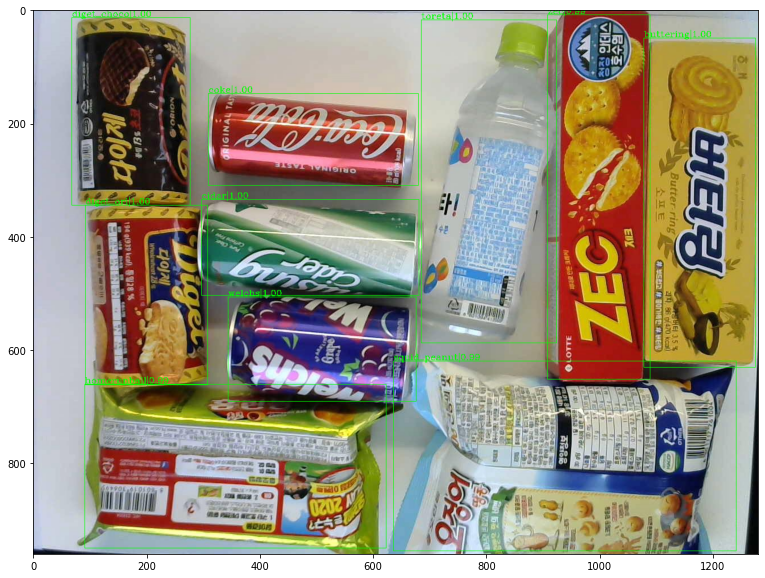

In [12]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('datasets/train/images/0046.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [14]:
torch.save(model.state_dict(), 'save_state_dict/FasterRCNN_model_state_dict.pt')

In [16]:
torch.save(model, 'save_model/FasterRCNN_model.pt')